In [ ]:
# General Libraries
import os
import math
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Google Colab
from google.colab import drive
import gdown
import joblib

# Scikit-learn (Data Processing & ML)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error

# TensorFlow & Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import load_model
import gc
import tensorflow.keras.backend as K

In [1]:
# Define File IDs from Google Drive
CSV_FILE_ID = "1--7jIKTCbZYbcqBhf4WWNk9XYGiskMUy"
JSON_FILE_ID = "1-Coff2iGNVDvnZAN-ku1-cOfbpqymdfM"
PICKLE_FILE_ID = "1-1Sjs3OKqw75dbJ9yi59Oa3gGArt8P_u"

# Define Local Save Paths
CSV_PATH = "/content/processed_data.csv"
JSON_PATH = "/content/processed_data.json"
PICKLE_PATH = "/content/processed_data.pkl"

# Function to download files
def download_file(file_id, output_path):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, output_path, quiet=False)

# Download Each File
download_file(CSV_FILE_ID, CSV_PATH)
download_file(JSON_FILE_ID, JSON_PATH)
download_file(PICKLE_FILE_ID, PICKLE_PATH)

print(" All files downloaded successfully!")

# Load the dataset from CSV
merged_df = pd.read_csv(CSV_PATH)

# Display first few rows to confirm
print("🔍 Sample Data:")
display(merged_df.head())

# Try loading Pickle (Fastest format)
try:
    print("Downloading Pickle dataset...")
    gdown.download(f"https://drive.google.com/uc?id={PICKLE_FILE_ID}", PICKLE_PATH, quiet=False)
    merged_df = pd.read_pickle(PICKLE_PATH)
    print("Loaded dataset from Pickle!")
except Exception as e:
    print("ok Pickle file not found, trying CSV...", e)

    # Fallback to CSV (If Pickle fails)
    try:
        print("Downloading CSV dataset...")
        gdown.download(f"https://drive.google.com/uc?id={CSV_FILE_ID}", CSV_PATH, quiet=False)
        merged_df = pd.read_csv(CSV_PATH)
        print("Loaded dataset from CSV!")
    except Exception as e:
        print("ERROR: Unable to load dataset!", e)
        exit()

# Load real-time JSON data (if available)
try:
    print("Downloading JSON dataset...")
    gdown.download(f"https://drive.google.com/uc?id={JSON_FILE_ID}", JSON_PATH, quiet=False)
    with open(JSON_PATH, "r") as json_file:
        json_data = json.load(json_file)
    print("Loaded JSON data for app integration!")
except Exception as e:
    print("⚠ JSON file not found, skipping real-time data.", e)

NameError: name 'y_test' is not defined

In [ ]:
# Prepare data split for TPU training

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # detect
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("All TPU devices: ", tf.config.list_logical_devices('TPU'))
except ValueError:
    # Fallback to CPU or GPU if TPU not found
    strategy = tf.distribute.get_strategy()


time_steps = 8
with strategy.scope():
    model = Sequential([
        LSTM(32, activation="relu", return_sequences=True, input_shape=(time_steps, 3)),
        LSTM(16, activation="relu"),
        Dense(3)  # Predict total_hvac, total_lighting, total_mels
    ])
    model.compile(optimizer="adam", loss="mae")

# Load and Preprocess Data
merged_df["date"] = pd.to_datetime(merged_df["date"])

# Select First 3 Months Before COVID
df_3m = merged_df[(merged_df["date"] >= "2020-01-01") & (merged_df["date"] < "2020-04-01")].copy()

# Reduce Dataset Size to Prevent RAM Overflow
#df_3m = df_3m.sample(n=50000, random_state=42)  # Use only 50K rows

# Feature Engineering
df_3m["hour"] = df_3m["date"].dt.hour  # Hour of the day
df_3m["day_of_week"] = df_3m["date"].dt.dayofweek  # Monday=0, Sunday=6

# Define LSTM Time Steps
# Use past 8 hours to predict the next hour

# Convert Data to Numpy Arrays for Training
data = df_3m[["total_hvac", "total_lighting", "total_mels"]].values

X = np.array([data[i:i+time_steps] for i in range(0, len(data) - time_steps)])
y = np.array([data[i+time_steps] for i in range(0, len(data) - time_steps)])

print(f"Optimized Training Data Shape: X={X.shape}, y={y.shape}")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert Data to Efficient TensorFlow Dataset
BATCH_SIZE = 32  # TPU prefers large batches
BUFFER_SIZE = 10000

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def prepare_tpu_dataset(X, y, batch_size=32, buffer_size=10000):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_data = prepare_tpu_dataset(X_train, y_train)
test_data = prepare_tpu_dataset(X_test, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Optimized Training Data Shape: X=(27654, 8, 3), y=(27654, 3)


In [ ]:
# Train model for predicting hourly energy usage using a TPU
model.fit(train_data, epochs=5, validation_data=test_data, verbose=1)

# Save model
model.save("hourly_energy_prediction.keras")  # or .pb, or a folder with tf.saved_model

# Save to drive for reuse
drive.mount('/content/drive')

MODEL_PATH = "/content/drive/MyDrive/connect_models/"

# Ensure the directory exists
os.makedirs(MODEL_PATH, exist_ok=True)

# Save the trained model
model.save(f"{MODEL_PATH}hourly_energy_prediction.keras")

print(f"Model saved to {MODEL_PATH}hourly_energy_prediction.keras")

print("Model Trained and saved!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model not found in /content/hourly_energy_prediction.keras, loading from Google Drive...
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model Evaluated!
Normalized MAE - HVAC: 0.02
Normalized MAE - Lighting: 0.01
Normalized MAE - MELS: 0.02

Unnormalized MAE - HVAC: 0.68 kWh
Unnormalized MAE - Lighting: 0.15 kWh
Unnormalized MAE - MELS: 0.18 kWh


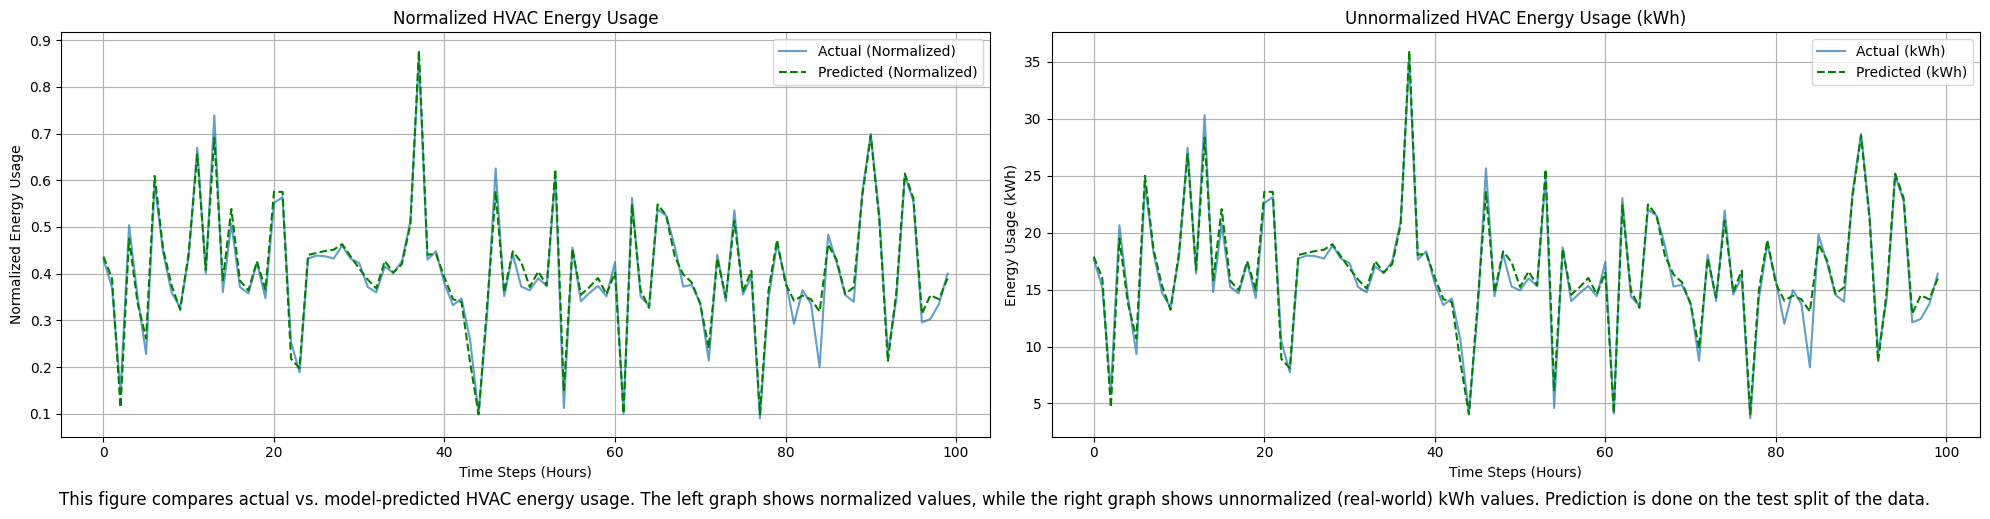

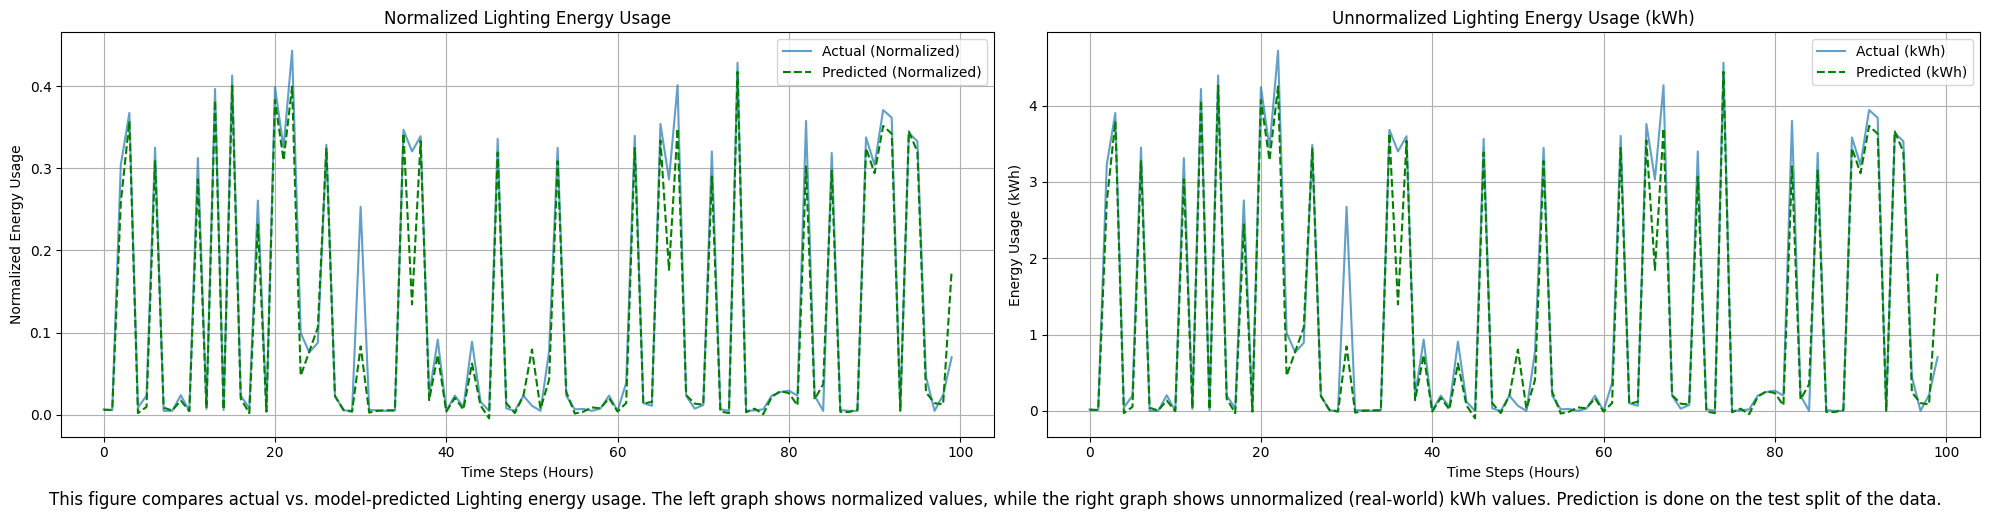

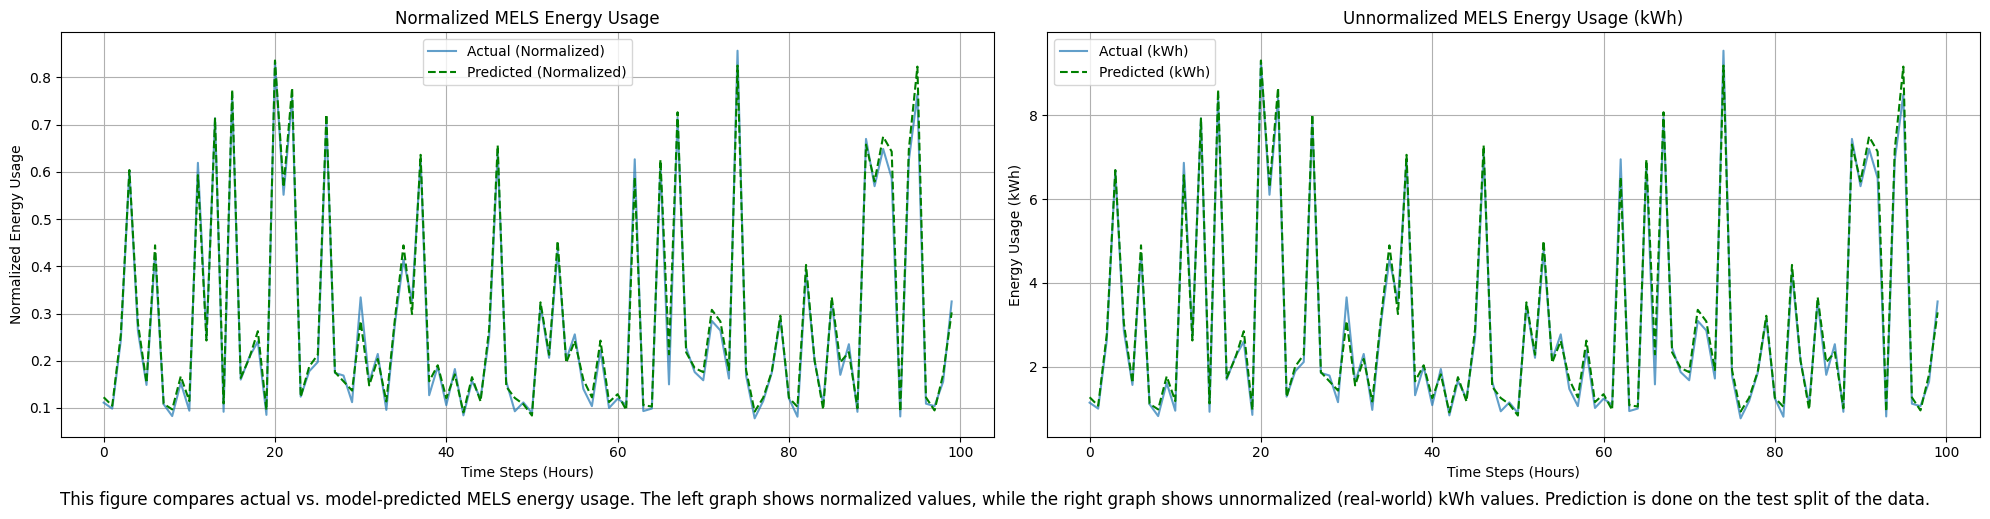

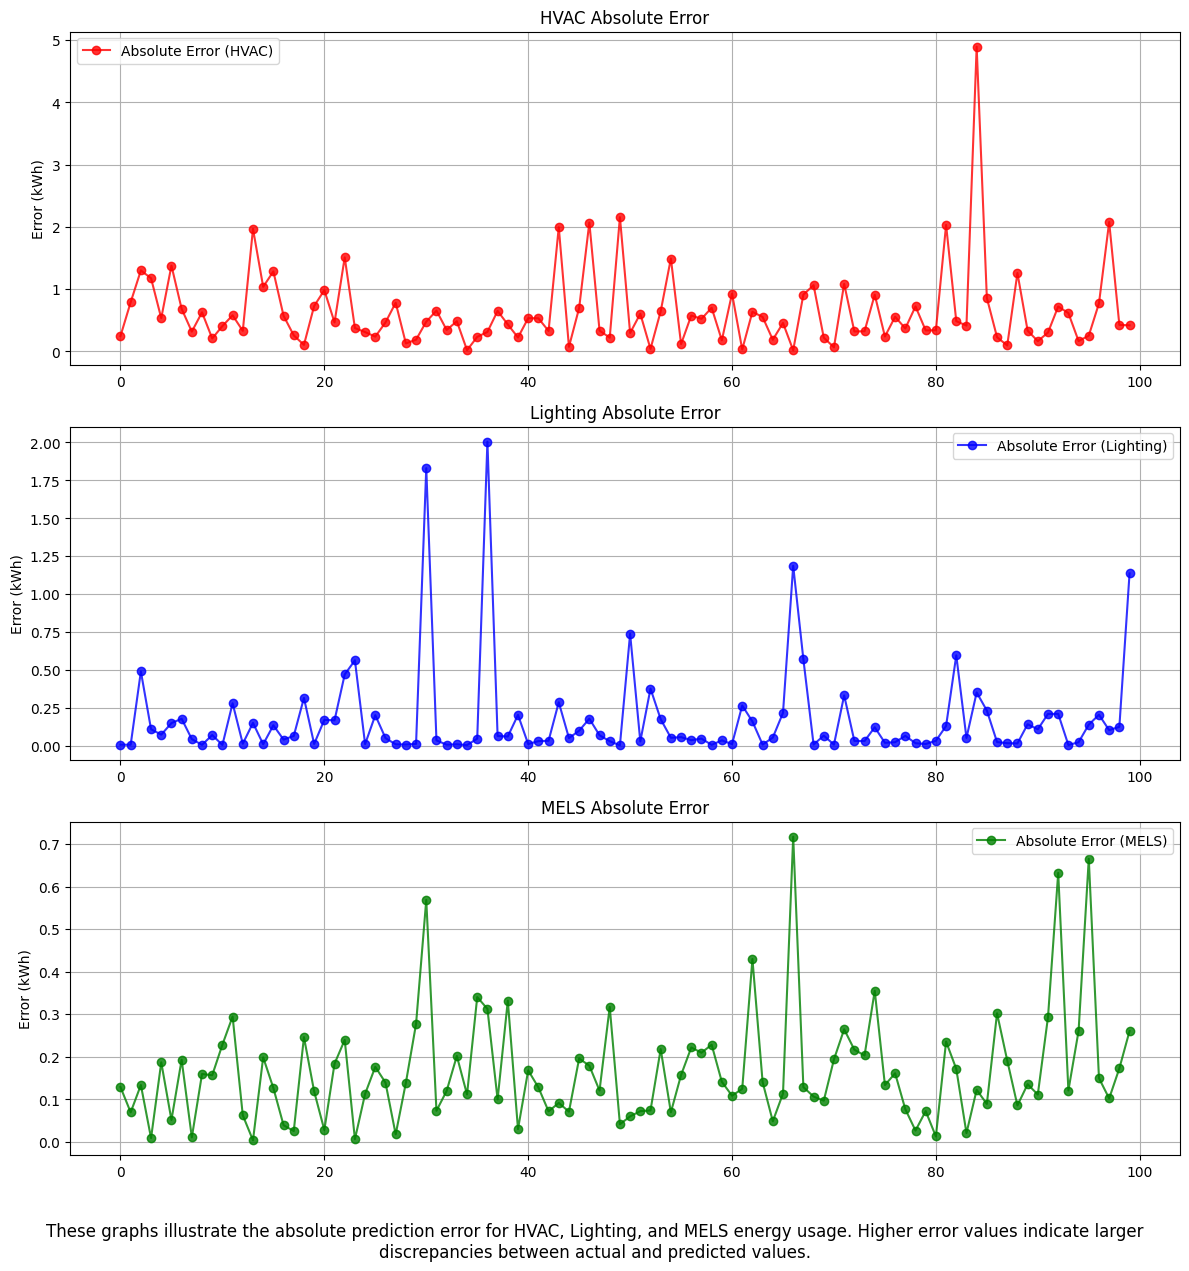

<Figure size 1200x500 with 0 Axes>

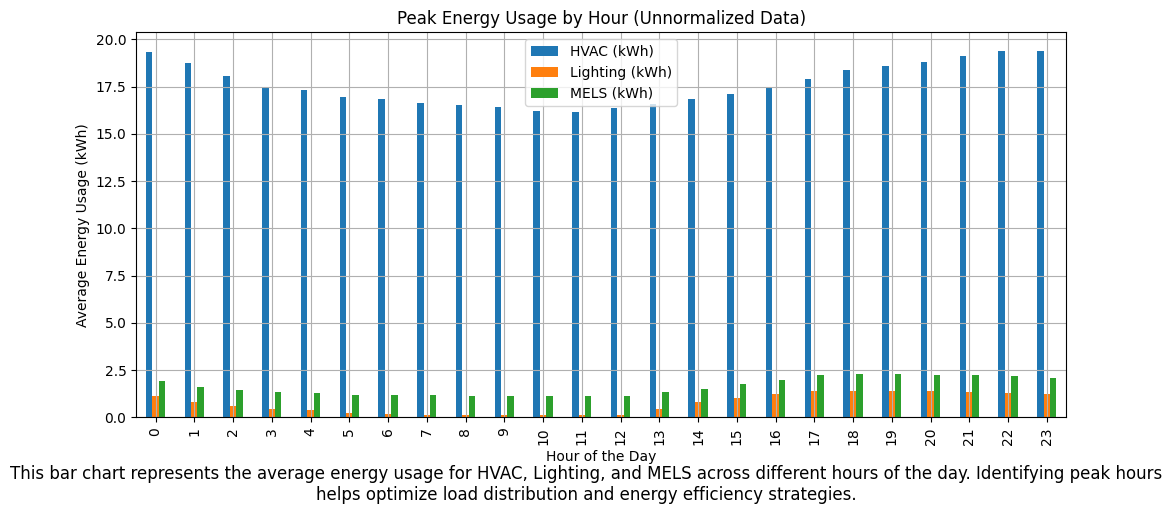

Successfully extracted and unnormalized 24 hourly HVAC data points for 2020-01-15
Total Cost Before Load Shifting: 90.17
Total Cost After Load Shifting: 82.05
Total Savings: 8.12 (9.00% reduction)


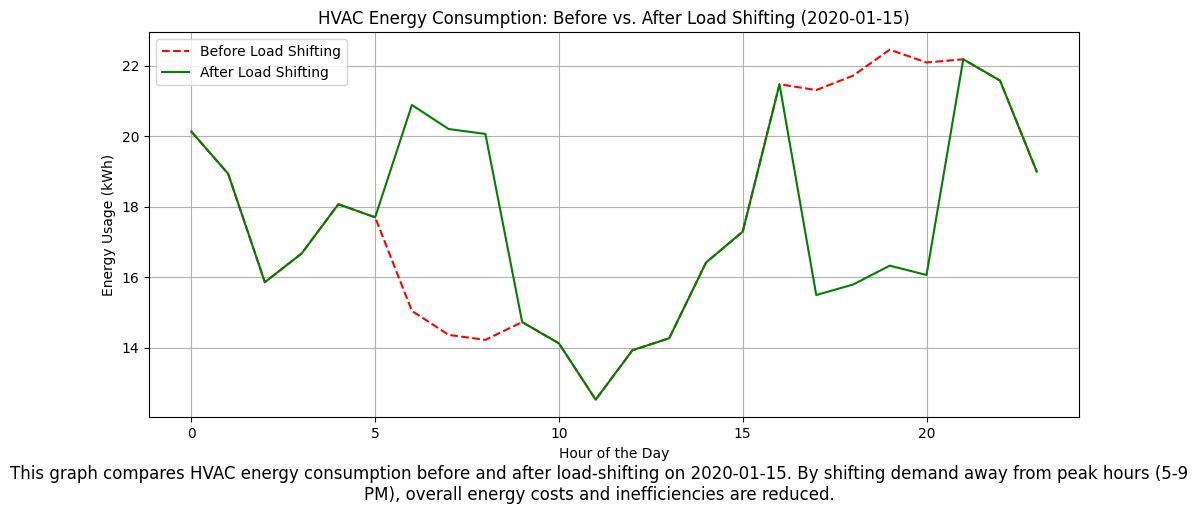

In [ ]:
# Predict & evaluate the model

# Define paths
SCALAR_PATH = "/content/drive/MyDrive/scalars/"
LOCAL_MODEL_PATH = "/content/hourly_energy_prediction.keras"
DRIVE_MODEL_PATH = "/content/drive/MyDrive/connect_models/hourly_energy_prediction.keras"

# Mount Google Drive
drive.mount('/content/drive')

# Check if the model exists in /content/ first, else load from Google Drive
if os.path.exists(LOCAL_MODEL_PATH):
    print(f"Loading model from {LOCAL_MODEL_PATH}")
    model = load_model(LOCAL_MODEL_PATH)
else:
    print(f"Model not found in {LOCAL_MODEL_PATH}, loading from Google Drive...")
    model = load_model(DRIVE_MODEL_PATH)

# Mount Google Drive and Load the MinMaxScaler
scaler_features = joblib.load(f"{SCALAR_PATH}scaler_features.pkl")
scaler_y = joblib.load(f"{SCALAR_PATH}scaler_y.pkl")

# Load Model & Predict
y_pred = model.predict(X_test, batch_size=32)

# Inverse Transform to Get Unnormalized Values (Real kWh)
y_test_original = scaler_y.inverse_transform(y_test)
y_pred_original = scaler_y.inverse_transform(y_pred)

# Calculate MAE for Normalized and Unnormalized Data
mae_hvac_norm = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_lighting_norm = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
mae_mels_norm = mean_absolute_error(y_test[:, 2], y_pred[:, 2])

mae_hvac = mean_absolute_error(y_test_original[:, 0], y_pred_original[:, 0])
mae_lighting = mean_absolute_error(y_test_original[:, 1], y_pred_original[:, 1])
mae_mels = mean_absolute_error(y_test_original[:, 2], y_pred_original[:, 2])

# Print MAE Results
print("Model Evaluated!")
print(f"Normalized MAE - HVAC: {mae_hvac_norm:.2f}")
print(f"Normalized MAE - Lighting: {mae_lighting_norm:.2f}")
print(f"Normalized MAE - MELS: {mae_mels_norm:.2f}\n")

print(f"Unnormalized MAE - HVAC: {mae_hvac:.2f} kWh")
print(f"Unnormalized MAE - Lighting: {mae_lighting:.2f} kWh")
print(f"Unnormalized MAE - MELS: {mae_mels:.2f} kWh")


def plot_energy_usage_separate(y_test_norm, y_pred_norm, y_test_kwh, y_pred_kwh, category):
    """
    Plots two separate graphs:
    - One for normalized data
    - One for unnormalized data
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    # Normalized Plot
    axes[0].plot(y_test_norm[:100], label="Actual (Normalized)", alpha=0.7)
    axes[0].plot(y_pred_norm[:100], label="Predicted (Normalized)", linestyle="dashed", color = "green")
    axes[0].set_title(f"Normalized {category} Energy Usage")
    axes[0].set_xlabel("Time Steps (Hours)")
    axes[0].set_ylabel("Normalized Energy Usage")
    axes[0].legend()
    axes[0].grid(True)

    # Unnormalized Plot
    axes[1].plot(y_test_kwh[:100], label="Actual (kWh)", linestyle="solid", alpha=0.7)
    axes[1].plot(y_pred_kwh[:100], label="Predicted (kWh)", linestyle="dashed", color = "green")
    axes[1].set_title(f"Unnormalized {category} Energy Usage (kWh)")
    axes[1].set_xlabel("Time Steps (Hours)")
    axes[1].set_ylabel("Energy Usage (kWh)")
    axes[1].legend()
    axes[1].grid(True)

    plt.figtext(0.5, -0.02, f"This figure compares actual vs. model-predicted {category} energy usage. The left graph shows normalized values, "
                            f"while the right graph shows unnormalized (real-world) kWh values. Prediction is done on the test split of the data.", wrap=True, horizontalalignment='center', fontsize=12)

    plt.tight_layout()
    plt.show()

# Plot Normalized & Unnormalized Data Separately
plot_energy_usage_separate(y_test[:, 0], y_pred[:, 0], y_test_original[:, 0], y_pred_original[:, 0], "HVAC")
plot_energy_usage_separate(y_test[:, 1], y_pred[:, 1], y_test_original[:, 1], y_pred_original[:, 1], "Lighting")
plot_energy_usage_separate(y_test[:, 2], y_pred[:, 2], y_test_original[:, 2], y_pred_original[:, 2], "MELS")

# Compute Absolute Errors on Unnormalized Data
error_hvac = np.abs(y_test_original[:100, 0] - y_pred_original[:100, 0])
error_lighting = np.abs(y_test_original[:100, 1] - y_pred_original[:100, 1])
error_mels = np.abs(y_test_original[:100, 2] - y_pred_original[:100, 2])

# Plot Absolute Errors
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# HVAC
axes[0].plot(error_hvac, label="Absolute Error (HVAC)", alpha=0.8, marker="o", color="red")
axes[0].set_title("HVAC Absolute Error")
axes[0].set_ylabel("Error (kWh)")
axes[0].grid(True)
axes[0].legend()

# Lighting
axes[1].plot(error_lighting, label="Absolute Error (Lighting)", alpha=0.8, marker="o", color="blue")
axes[1].set_title("Lighting Absolute Error")
axes[1].set_ylabel("Error (kWh)")
axes[1].grid(True)
axes[1].legend()

# MELS
axes[2].plot(error_mels, label="Absolute Error (MELS)", alpha=0.8, marker="o", color="green")
axes[2].set_title("MELS Absolute Error")
axes[2].set_ylabel("Error (kWh)")
axes[2].grid(True)
axes[2].legend()


plt.tight_layout()
plt.figtext(0.5, -0.05, "These graphs illustrate the absolute prediction error for HVAC, Lighting, and MELS energy usage. "
                        "Higher error values indicate larger discrepancies between actual and predicted values.", wrap=True,
            horizontalalignment='center', fontsize=12)
plt.show()

# Peak Energy Usage by Hour (Unnormalized)
hourly_avg = merged_df.groupby("hour")[["total_hvac", "total_lighting", "total_mels"]].mean()
hourly_avg_kwh = scaler_y.inverse_transform(hourly_avg)

hourly_avg_df = pd.DataFrame(hourly_avg_kwh, columns=["HVAC (kWh)", "Lighting (kWh)", "MELS (kWh)"], index=range(24))
# Plot figure
plt.figure(figsize=(12, 5))
hourly_avg_df.plot(kind="bar", figsize=(12, 5))
plt.title("Peak Energy Usage by Hour (Unnormalized Data)")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Energy Usage (kWh)")
plt.legend()
plt.grid(True)

plt.figtext(0.5, -0.05, "This bar chart represents the average energy usage for HVAC, Lighting, and MELS across different hours of the day. "
                        "Identifying peak hours helps optimize load distribution and energy efficiency strategies.", wrap=True,
            horizontalalignment='center', fontsize=12)

plt.show()

# Run some simulations for savings
# Select a specific day for analysis (change the date as needed)
selected_date = "2020-01-15"

# Convert 'date' column to datetime (if not already)
merged_df["date"] = pd.to_datetime(merged_df["date"])

hvac_before = (
    merged_df.set_index("date")
    .loc[selected_date, ["total_hvac"]]  # Select only HVAC column
    .resample("h")
    .mean()
    .interpolate()  # Fill missing hourly values if needed
    .values
)

# Reshape to 2D before inverse transform (since scaler expects 2D input)
hvac_before = hvac_before.reshape(-1, 1)

# Inverse transform using only the first column of scaler_y
hvac_before = scaler_y.inverse_transform(
    np.hstack([hvac_before, np.zeros((24, 2))])  # Add dummy columns for Lighting & MELS
)[:, 0]  # Extract only the first column (HVAC)

# Ensure exactly 24 values exist
if len(hvac_before) != 24:
    raise ValueError(f"Selected date {selected_date} does not contain exactly 24 hourly values. Found: {len(hvac_before)}")

print(f"Successfully extracted and unnormalized 24 hourly HVAC data points for {selected_date}")

# Define parameters at the start of the script
peak_hours = [17, 18, 19, 20]  # Peak demand time (5-9 PM)
shift_percentage = 0.20  # 20% of peak energy usage can be shifted
efficiency_loss = 1.1  # Assume 10% inefficiency during peak hours
hours = np.arange(24)  # Define hours from 0 to 23 (24-hour format)

# Energy pricing rates
base_rate = 0.15  # Standard rate per kWh
peak_rate = 0.30  # Peak hour rate per kWh

# Compute peak demand before optimization
peak_energy_before = hvac_before[peak_hours].sum()

# Reduce peak energy and shift to non-peak hours
hvac_after = hvac_before.copy()
hvac_after[peak_hours] *= (1 - shift_percentage)  # Reduce peak usage
hvac_after[6:9] += (peak_energy_before * shift_percentage) / 3  # Shift to early morning hours

# Apply efficiency gain due to load reduction
hvac_after[peak_hours] /= efficiency_loss  # Reduce inefficiency factor

# Compute energy cost before and after
total_energy_before = hvac_before.sum()
total_energy_after = hvac_after.sum()

cost_before = (total_energy_before * base_rate) + (peak_energy_before * peak_rate)
cost_after = (total_energy_after * base_rate) + (hvac_after[peak_hours].sum() * peak_rate)

savings = cost_before - cost_after
percent_savings = (savings / cost_before) * 100

# Print results
print(f"Total Cost Before Load Shifting: {cost_before:.2f}")
print(f"Total Cost After Load Shifting: {cost_after:.2f}")
print(f"Total Savings: {savings:.2f} ({percent_savings:.2f}% reduction)")

# Plot comparison
plt.figure(figsize=(12, 5))
plt.plot(hours, hvac_before, label="Before Load Shifting", linestyle="dashed", color="red")
plt.plot(hours, hvac_after, label="After Load Shifting", linestyle="solid", color="green")
plt.title(f"HVAC Energy Consumption: Before vs. After Load Shifting ({selected_date})")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Usage (kWh)")
plt.legend()
plt.grid(True)

plt.figtext(0.5, -0.05, f"This graph compares HVAC energy consumption before and after load-shifting on {selected_date}. "
                        "By shifting demand away from peak hours (5-9 PM), overall energy costs and inefficiencies are reduced.",
            wrap=True, horizontalalignment='center', fontsize=12)

plt.show()